In [12]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.isotonic import IsotonicRegression

plt.rcParams["figure.figsize"] = (20,6)

### Funções

In [13]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [18]:
def apl_model (df_st,n_lags):

    print('Janela Analisada: ', n_lags,'dias\n')

    # X = get_lags(df_st, n_lags)
    # y = df_st.reindex(X.index)

    X = df_st['N_casos']
    y = df_st['N_casos']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'out_of_bounds':['nan', 'clip', 'raise'],
             'increasing': [True , False, 'auto'],
             }

    Lr = IsotonicRegression()
    Lr_GS = GridSearchCV (Lr, parameters, cv = TimeSeriesSplit())
    res = Lr_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'out_of_bounds': [res.best_params_['out_of_bounds']],
             'increasing': [res.best_params_['increasing']]}
    
    Lr = IsotonicRegression()
    Lr_GS = GridSearchCV (Lr, parameters, cv = TimeSeriesSplit())
    res = Lr_GS.fit(X_train,y_train)
    print( res.best_score_, res.best_params_)

    r2 = r2_score(Lr_GS.predict(X_test),y_test)
    mse = mean_squared_error(Lr_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(Lr_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(Lr_GS.predict(X_test),y_test)

    print('Model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)

    #plot previsão com teste
    fig, ax = plt.subplots()
    ax.plot(Lr_GS.predict(X_test).flatten(), label='Previsões', color = 'b')
    ax.plot(y_test.reset_index(drop=True), label='Real', color= 'y')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();


    #plot de total com previsão
    previsao = pd.DataFrame(Lr_GS.predict(X_test).flatten(), index = X_test.index)
    concat = pd.concat([y_train, previsao],axis=1)

    concat.plot(linewidth=2,figsize=(20,7), color=['y','b'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Real x Previsto',size=15)
    plt.show();

    fig, ax = plt.subplots()
    ax.plot(df_st, label='Real', color = 'y')
    ax.plot(previsao, label='Previsões', linewidth=2, color='b')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();


    
    return r2, mse, rmse, mae, mape
    

In [15]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30, 45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse, mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse, mae, mape]
        results.append(result)

    return results

### Lendo o dataset

In [16]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_6236\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicado o modelo

Janela Analisada:  7 dias

########################################
Melhor Score:  0.8029750913370938
Melhores Parametros:  {'increasing': True, 'out_of_bounds': 'clip'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.8029750913370938 {'increasing': True, 'out_of_bounds': 'clip'}
Model Results
r2 -0.5299001938393781
mse 1002779.3562753036
rmse 1001.3887138745391
mae 263.82591093117406
mape 0.0875334807336344


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py"

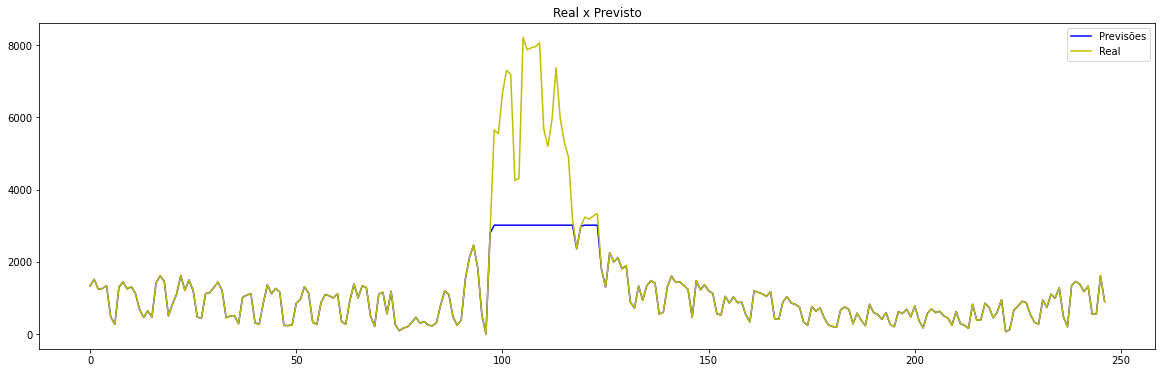

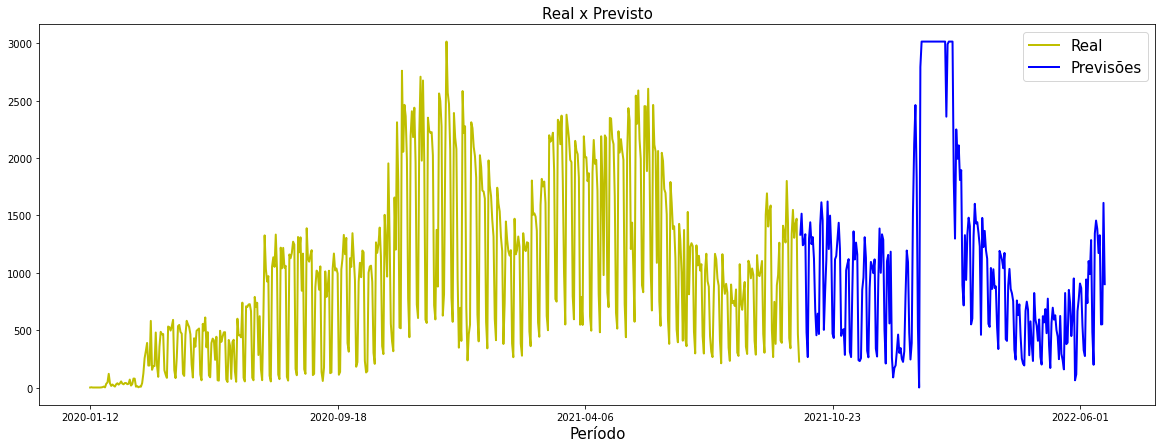

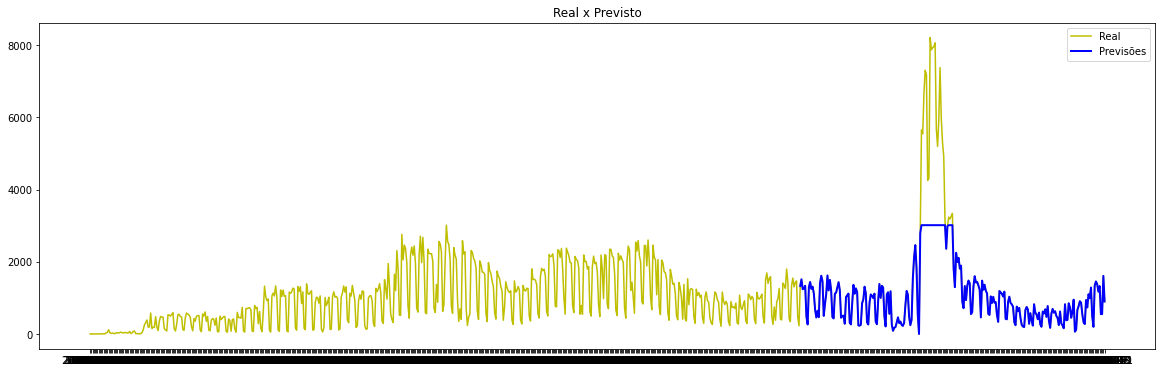

Janela Analisada:  15 dias

########################################
Melhor Score:  0.8029750913370938
Melhores Parametros:  {'increasing': True, 'out_of_bounds': 'clip'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.8029750913370938 {'increasing': True, 'out_of_bounds': 'clip'}
Model Results
r2 -0.5299001938393781
mse 1002779.3562753036
rmse 1001.3887138745391
mae 263.82591093117406
mape 0.0875334807336344


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py"

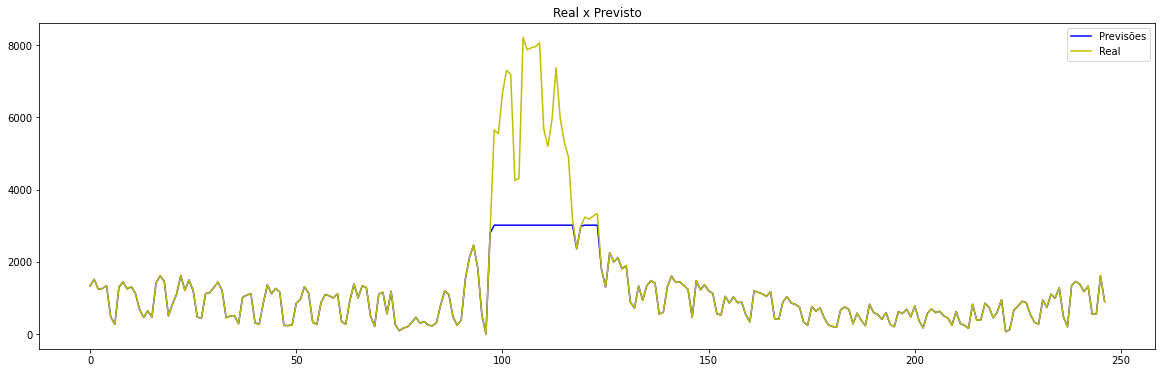

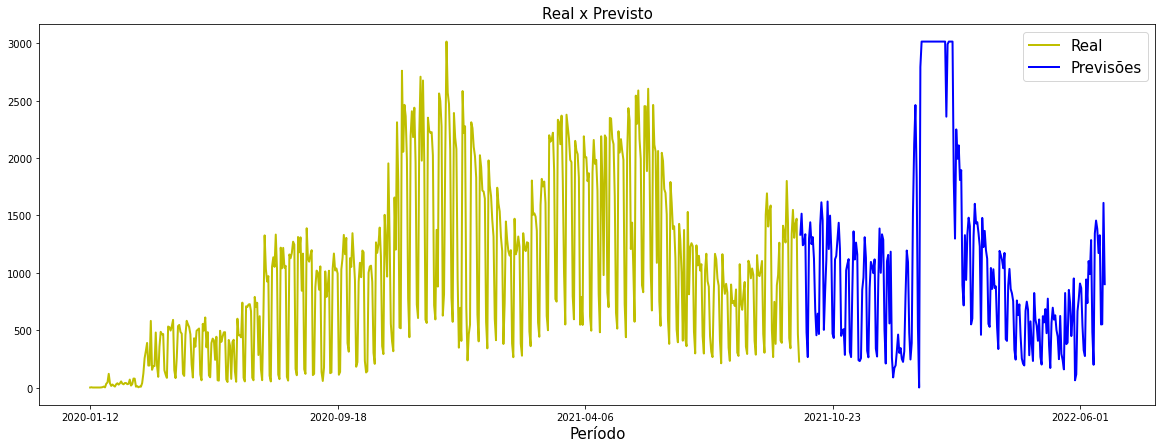

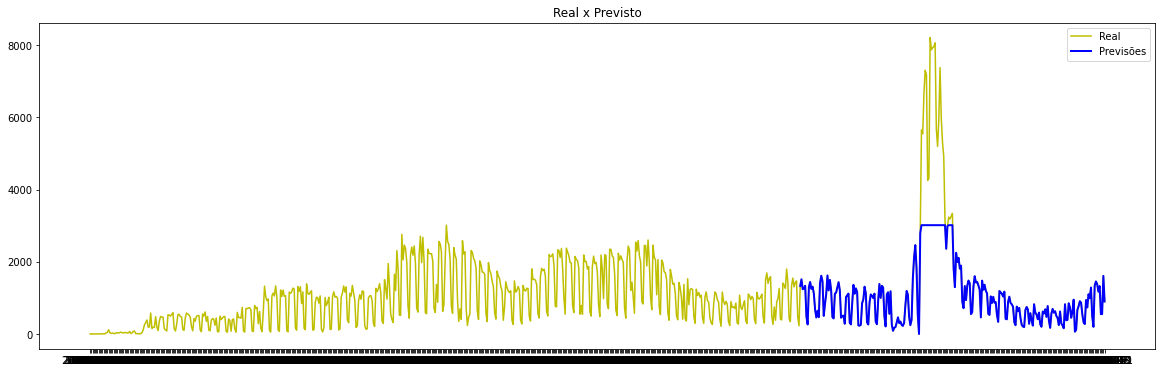

Janela Analisada:  30 dias

########################################
Melhor Score:  0.8029750913370938
Melhores Parametros:  {'increasing': True, 'out_of_bounds': 'clip'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.8029750913370938 {'increasing': True, 'out_of_bounds': 'clip'}
Model Results
r2 -0.5299001938393781
mse 1002779.3562753036
rmse 1001.3887138745391
mae 263.82591093117406
mape 0.0875334807336344


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py"

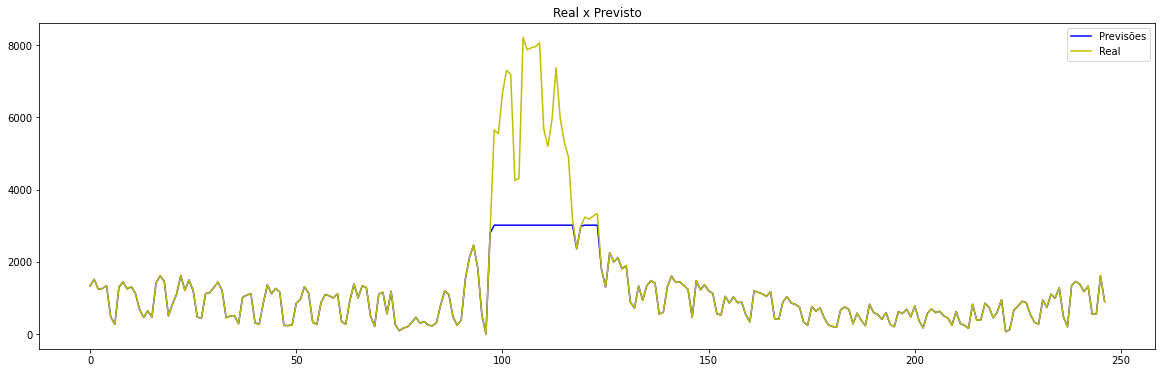

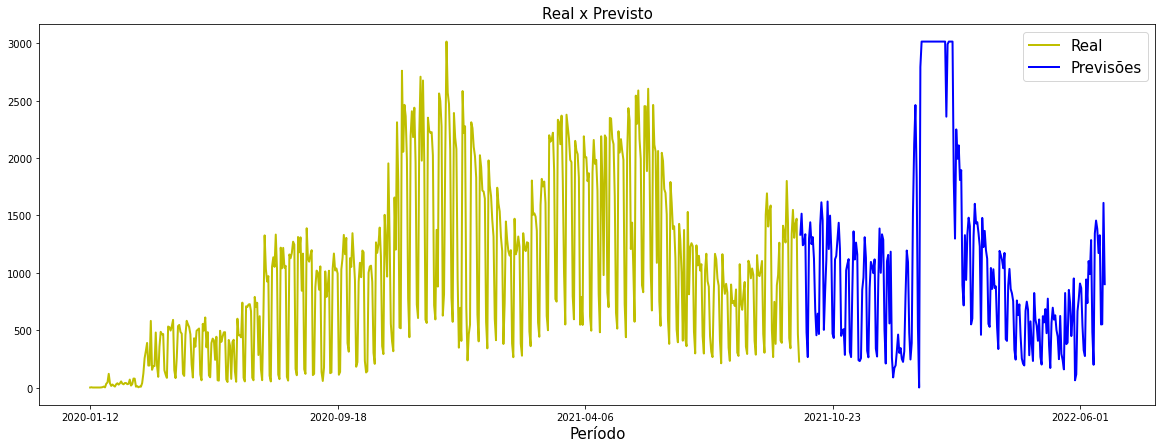

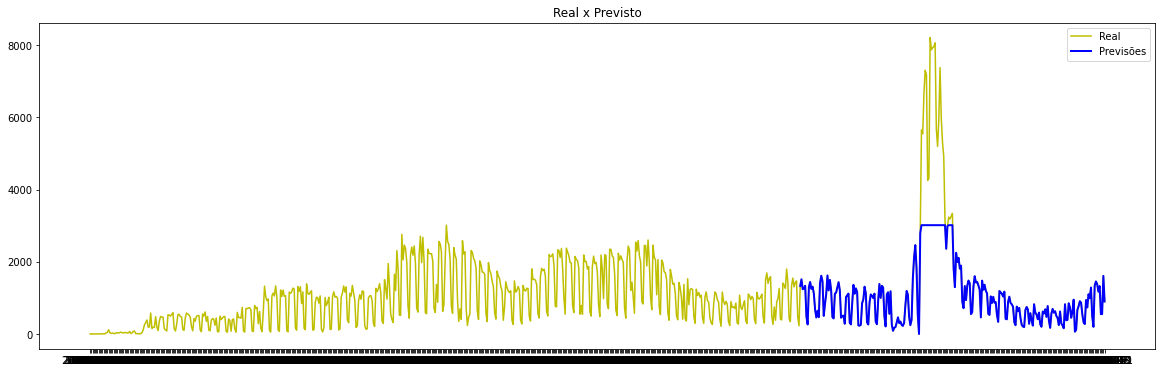

Janela Analisada:  45 dias

########################################
Melhor Score:  0.8029750913370938
Melhores Parametros:  {'increasing': True, 'out_of_bounds': 'clip'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.8029750913370938 {'increasing': True, 'out_of_bounds': 'clip'}
Model Results
r2 -0.5299001938393781
mse 1002779.3562753036
rmse 1001.3887138745391
mae 263.82591093117406
mape 0.0875334807336344


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py"

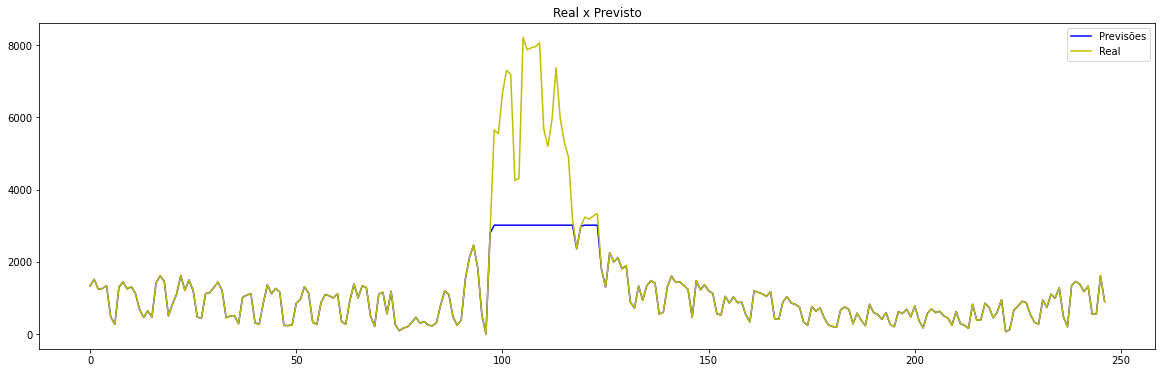

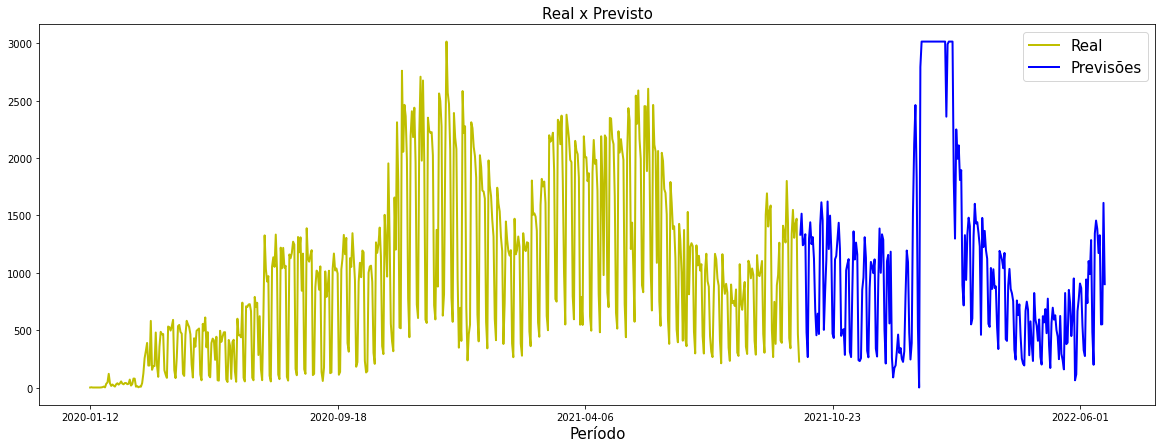

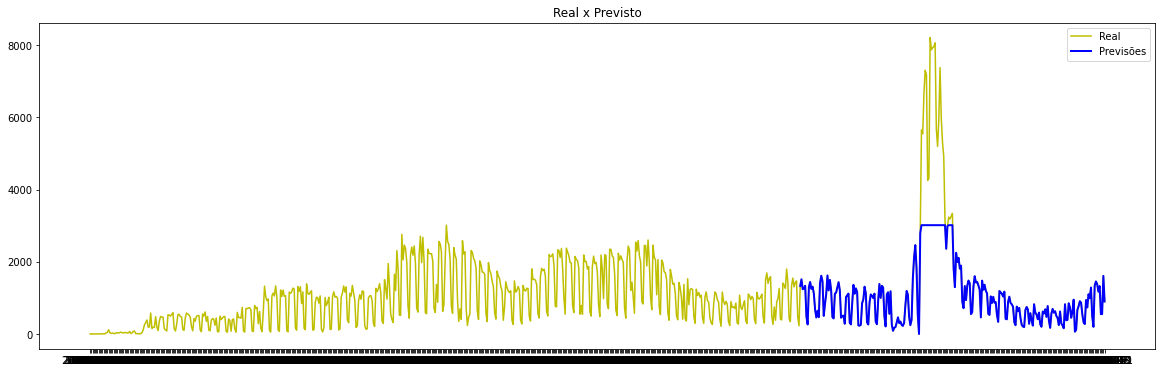

Janela Analisada:  60 dias

########################################
Melhor Score:  0.8029750913370938
Melhores Parametros:  {'increasing': True, 'out_of_bounds': 'clip'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.8029750913370938 {'increasing': True, 'out_of_bounds': 'clip'}
Model Results
r2 -0.5299001938393781
mse 1002779.3562753036
rmse 1001.3887138745391
mae 263.82591093117406
mape 0.0875334807336344


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py"

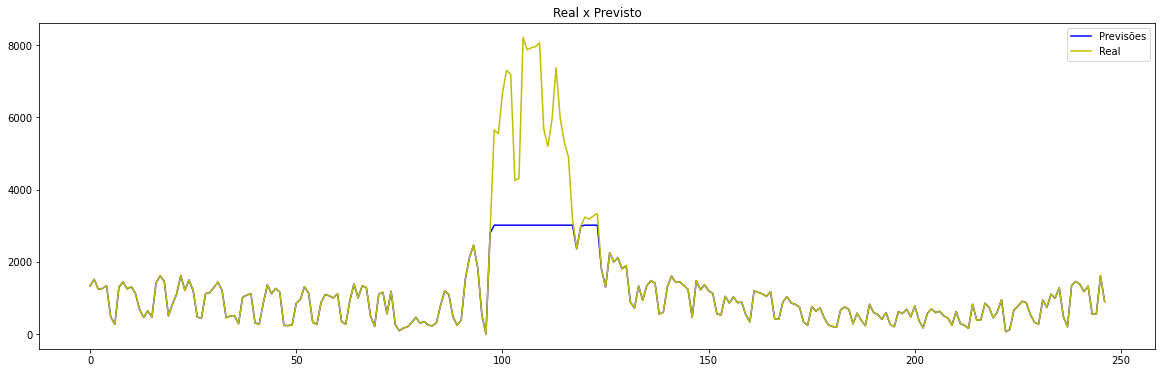

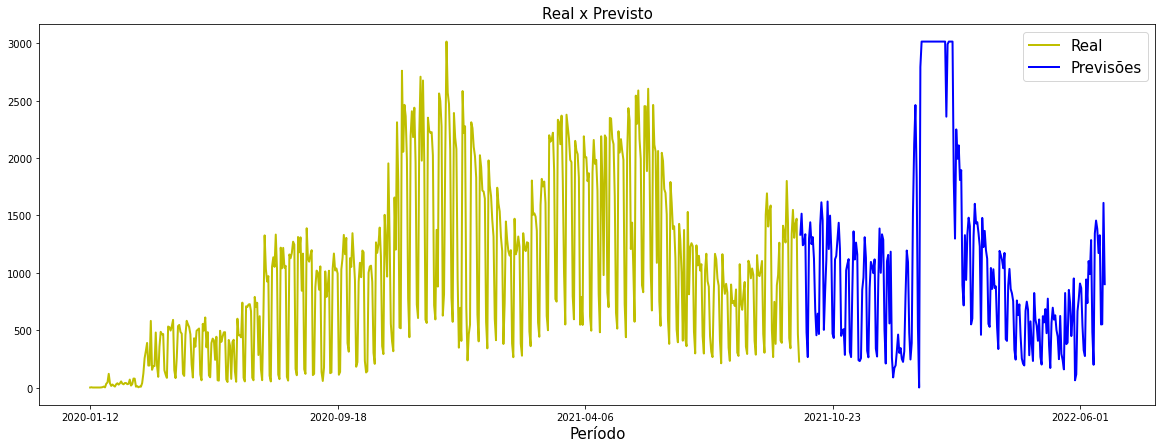

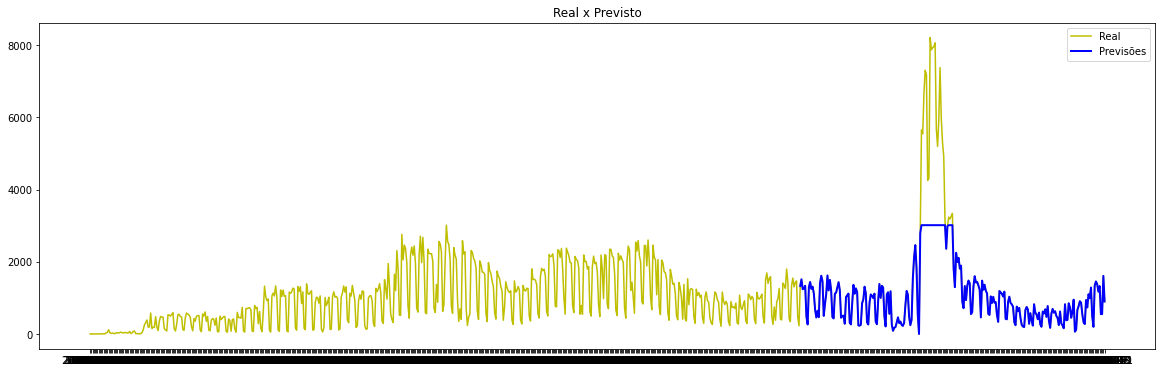

In [19]:
results = apl_for_lags (df_st)

### Resultados

In [ ]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results.sort_values(by='R2' , ascending = False)

,R2,MSE,RMSE,MAE,MAPE
7 dias,0.644235,8.154796e+05,903.039084,476.562910,0.392601
15 dias,0.490219,1.100186e+06,1048.897440,555.801590,0.407030
30 dias,0.411535,1.205930e+06,1098.148225,589.385081,0.419016
60 dias,0.395577,1.170706e+06,1081.991660,598.250521,0.430544
45 dias,0.374447,1.204032e+06,1097.283895,599.682757,0.424740
